<a href="https://colab.research.google.com/github/superp0tat0/PlayGround/blob/master/MNIST_Spectural_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi

Sat Jan 30 22:49:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import numpy as np                   # advanced math library
import matplotlib.pyplot as plt      # MATLAB like plotting routines
import random                        # for generating random numbers

from keras.datasets import mnist     # MNIST dataset is included in Keras
from keras.models import Sequential  # Model type to be used

from keras.layers.core import Dense, Dropout, Activation # Types of layers to be used in our model
from keras.utils import np_utils                         # NumPy related tools
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA as KPCA
from sklearn.model_selection import train_test_split

# import some additional tools
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, Flatten
from keras.layers.normalization import BatchNormalization

def model_status(model):
    for layer in model.layers:
      print(layer, layer.trainable)

def build_model_single_dense(first_layer_neuron = 32):
  model = Sequential()                                 # Linear stacking of layers
  model.add(Dense(first_layer_neuron))                
  model.add(Activation('relu'))                     # relu activation

  model.add(Dense(10))                                 # final 10 FCN nodes
  model.add(Activation('softmax'))                     # softmax activation
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

def build_model_complex_dense():
  model = Sequential()                                 # Linear stacking of layers
  model.add(Dense(32))
  model.add(BatchNormalization())             
  model.add(Activation('relu'))                     # relu activation

  model.add(Dense(64))
  model.add(BatchNormalization())             
  model.add(Activation('relu'))                     # relu activation

  model.add(Dense(128))
  model.add(BatchNormalization())             
  model.add(Activation('relu'))                     # relu activation

  model.add(Dense(64))
  model.add(BatchNormalization())             
  model.add(Activation('relu'))                     # relu activation

  model.add(Dense(32))
  model.add(BatchNormalization())             
  model.add(Activation('relu'))                     # relu activation

  model.add(Dense(10))                                 # final 10 FCN nodes
  model.add(Activation('softmax'))                     # softmax activation
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [3]:
# Reload the MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
#Flatten the X data for PCA features
X_train_Flatten = X_train.reshape(60000, 28*28)
X_test_Flatten = X_test.reshape(10000, 28*28)

X_train = X_train.astype('float32')         # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                              # normalize each value for each pixel for the entire vector for each input
X_test /= 255

nb_classes = 10 # number of unique digits
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)
y_random = np.array([random.randint(0,9) for i in range(60000)])
Y_random = np_utils.to_categorical(y_random, nb_classes)

In [ ]:
obj_pca = PCA(n_components=60)
obj_pca.fit(X_train_Flatten)

In [ ]:
pcs = obj_pca.components_.reshape(60,28,28)

(60, 28, 28)


# Empirical Study 1
What does the Principal Components look like for the whole dataset?


In [ ]:
plt.rcParams['figure.figsize'] = (30,12) # Make the figures a bit bigger

for i in range(32):
    plt.subplot(4,8,i+1)
    plt.imshow(pcs[i], cmap='gray', interpolation='none')
    
plt.tight_layout()

# Empirical Study 2a
Will PCA benefit of convergence? Yes

In [ ]:
# Treat the new PCs as the weights.
new_X_train = X_train_Flatten @ obj_pca.components_.T
new_X_test = X_test_Flatten @ obj_pca.components_.T
print(new_X_train.shape)
print(new_X_test.shape)

(60000, 60)
(10000, 60)


In [ ]:
pca_model = build_model_single_dense(32)
pca_history = pca_model.fit(x=new_X_train, y=Y_train, epochs=50, steps_per_epoch=100, validation_data=(new_X_test, Y_test))

In [ ]:
naive_dense = build_model_single_dense(32)
naive_history = naive_dense.fit(x=X_train_Flatten, y=Y_train, epochs=50, steps_per_epoch=100, validation_data=(X_test_Flatten, Y_test))

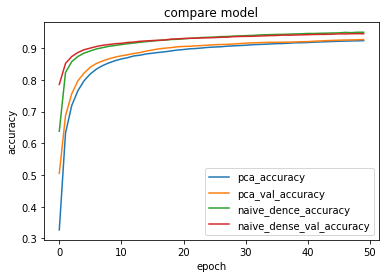

In [ ]:
%matplotlib inline
plt.plot(pca_history.history['accuracy'])
plt.plot(pca_history.history['val_accuracy'])
plt.plot(naive_history.history['accuracy'])
plt.plot(naive_history.history['val_accuracy'])
plt.title('compare model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['pca_accuracy', 'pca_val_accuracy', 'naive_dence_accuracy', 'naive_dense_val_accuracy'], loc='lower right')
plt.show()

# Empirical Study 2b
What does the simple dense layer work with the random labeled datasets?

In [ ]:
random_dense = build_model_complex_dense()
random_history = random_dense.fit(x = X_train_Flatten, y=Y_random, epochs=500, steps_per_epoch=100, validation_data=(X_test_Flatten, Y_test))

Epoch 1/500
100/100 [==============================] - 2s 14ms/step - loss: 2.4649 - accuracy: 0.0996 - val_loss: 2.3107 - val_accuracy: 0.1156
Epoch 2/500
100/100 [==============================] - 1s 10ms/step - loss: 2.3020 - accuracy: 0.1189 - val_loss: 2.3390 - val_accuracy: 0.0862
Epoch 3/500
100/100 [==============================] - 1s 10ms/step - loss: 2.2879 - accuracy: 0.1291 - val_loss: 2.3172 - val_accuracy: 0.1035
Epoch 4/500
100/100 [==============================] - 1s 10ms/step - loss: 2.2808 - accuracy: 0.1361 - val_loss: 2.3007 - val_accuracy: 0.1156
Epoch 5/500
100/100 [==============================] - 1s 10ms/step - loss: 2.2724 - accuracy: 0.1439 - val_loss: 2.3041 - val_accuracy: 0.1249
Epoch 6/500
100/100 [==============================] - 1s 10ms/step - loss: 2.2640 - accuracy: 0.1533 - val_loss: 2.3255 - val_accuracy: 0.1033
Epoch 7/500
100/100 [==============================] - 1s 10ms/step - loss: 2.2594 - accuracy: 0.1553 - val_loss: 2.3691 - val_accuracy:

# The codes below this section will be the CNN network


In [ ]:
# Reload the MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 28, 28, 1) #add an additional dimension to represent the single-channel
X_test = X_test.reshape(10000, 28, 28, 1)

X_train = X_train.astype('float32')         # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                              # normalize each value for each pixel for the entire vector for each input
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
Training matrix shape (60000, 28, 28, 1)
Testing matrix shape (10000, 28, 28, 1)


In [ ]:
# one-hot format classes

nb_classes = 10 # number of unique digits

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

In [ ]:
def build_model(first_dense=512):
  model = Sequential()                                 # Linear stacking of layers
  # Convolution Layer 1
  model.add(Conv2D(32, (3, 3), input_shape=(28,28,1))) # 32 different 3x3 kernels -- so 32 feature maps
  model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
  convLayer01 = Activation('relu')                     # activation
  model.add(convLayer01)

  # Convolution Layer 2
  model.add(Conv2D(32, (3, 3)))                        # 32 different 3x3 kernels -- so 32 feature maps
  model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
  model.add(Activation('relu'))                        # activation
  convLayer02 = MaxPooling2D(pool_size=(2,2))          # Pool the max values over a 2x2 kernel
  model.add(convLayer02)

  # Convolution Layer 3
  model.add(Conv2D(64,(3, 3)))                         # 64 different 3x3 kernels -- so 64 feature maps
  model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
  convLayer03 = Activation('relu')                     # activation
  model.add(convLayer03)

  # Convolution Layer 4
  model.add(Conv2D(64, (3, 3)))                        # 64 different 3x3 kernels -- so 64 feature maps
  model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
  model.add(Activation('relu'))                        # activation
  convLayer04 = MaxPooling2D(pool_size=(2,2))          # Pool the max values over a 2x2 kernel
  model.add(convLayer04)
  model.add(Flatten())                                 # Flatten final 4x4x64 output matrix into a 1024-length vector

  # Fully Connected Layer 5
  model.add(Dense(first_dense))                                # 512 FCN nodes
  model.add(BatchNormalization())                      # normalization
  model.add(Activation('relu'))                        # activation

  # Fully Connected Layer 6
  model.add(Dense(10))                                 # final 10 FCN nodes
  model.add(Activation('softmax'))                     # softmax activationss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [ ]:
CNN_model = build_model()
print(CNN_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0

In [ ]:
CNN_history = CNN_model.fit(x=X_train, y=Y_train, epochs=50, steps_per_epoch=100, validation_data=(X_test, Y_test))

#Third Empirical Study: Unlabeled data take the majority, and verify the pretrained steps.

In [12]:
"""
# Reload the MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
#Flatten the X data for PCA features
X_train_Flatten = X_train.reshape(60000, 28*28)
X_test_Flatten = X_test.reshape(10000, 28*28)

X_train = X_train.astype('float32')         # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                              # normalize each value for each pixel for the entire vector for each input
X_test /= 255

nb_classes = 10 # number of unique digits
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)
"""

#Futher more, decompose the train set to unlabel train set and label train set. We will try to tranfer the PCA from unlabel dataset to the label dataset.

X_unlabel, X_label, y_unlabel, y_label = train_test_split(X_train, y_train, test_size = 0.5)
X_unlabel_Flatten = X_unlabel.reshape(30000, 28*28)
X_label_Flatten = X_label.reshape(30000, 28*28)

Y_unlabel = np_utils.to_categorical(y_unlabel, nb_classes)
Y_label = np_utils.to_categorical(y_label, nb_classes)

In [14]:
#Do the PCA here
obj_kpca = KPCA(n_components=32, kernel="rbf")
transformed_X = obj_kpca.fit_transform(X_label_Flatten)

In [15]:
#Do the PCA here
obj_pca_naive = PCA(n_components=32)
obj_pca_naive.fit(X_label_Flatten)

PCA(copy=True, iterated_power='auto', n_components=32, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [17]:
new_X_train = X_label_Flatten @ obj_pca_naive.components_.T #Map the unlabel PCs with the labeled dataset
print(new_X_train.shape)
print(transformed_X.shape)

(30000, 32)
(30000, 32)


In [20]:
K_pca = build_model_single_dense(32)
Kpca_history = K_pca.fit(x=transformed_X, y=Y_label, epochs=50, validation_split=0.2)

Epoch 1/50
750/750 [==============================] - 3s 2ms/step - loss: 2.0382 - accuracy: 0.4486 - val_loss: 1.0003 - val_accuracy: 0.7962
Epoch 2/50
750/750 [==============================] - 1s 2ms/step - loss: 0.8484 - accuracy: 0.8181 - val_loss: 0.5715 - val_accuracy: 0.8632
Epoch 3/50
750/750 [==============================] - 2s 2ms/step - loss: 0.5329 - accuracy: 0.8650 - val_loss: 0.4584 - val_accuracy: 0.8757
Epoch 4/50
750/750 [==============================] - 2s 2ms/step - loss: 0.4456 - accuracy: 0.8772 - val_loss: 0.4159 - val_accuracy: 0.8845
Epoch 5/50
750/750 [==============================] - 2s 2ms/step - loss: 0.4090 - accuracy: 0.8828 - val_loss: 0.3929 - val_accuracy: 0.8872
Epoch 6/50
750/750 [==============================] - 2s 2ms/step - loss: 0.3821 - accuracy: 0.8901 - val_loss: 0.3812 - val_accuracy: 0.8888
Epoch 7/50
750/750 [==============================] - 2s 2ms/step - loss: 0.3748 - accuracy: 0.8898 - val_loss: 0.3693 - val_accuracy: 0.8915
Epoch 

In [21]:
naive_pca = build_model_single_dense(32)
naive_pca_history = naive_pca.fit(x=new_X_train, y=Y_label, epochs=50, validation_split=0.2)

Epoch 1/50
750/750 [==============================] - 2s 2ms/step - loss: 1.4953 - accuracy: 0.5233 - val_loss: 0.4348 - val_accuracy: 0.8783
Epoch 2/50
750/750 [==============================] - 2s 2ms/step - loss: 0.3948 - accuracy: 0.8859 - val_loss: 0.3507 - val_accuracy: 0.8980
Epoch 3/50
750/750 [==============================] - 2s 2ms/step - loss: 0.3344 - accuracy: 0.9007 - val_loss: 0.3158 - val_accuracy: 0.9062
Epoch 4/50
750/750 [==============================] - 2s 2ms/step - loss: 0.2926 - accuracy: 0.9156 - val_loss: 0.2859 - val_accuracy: 0.9130
Epoch 5/50
750/750 [==============================] - 2s 2ms/step - loss: 0.2588 - accuracy: 0.9253 - val_loss: 0.2673 - val_accuracy: 0.9242
Epoch 6/50
750/750 [==============================] - 2s 2ms/step - loss: 0.2402 - accuracy: 0.9303 - val_loss: 0.2562 - val_accuracy: 0.9270
Epoch 7/50
750/750 [==============================] - 2s 2ms/step - loss: 0.2279 - accuracy: 0.9335 - val_loss: 0.2333 - val_accuracy: 0.9322
Epoch 

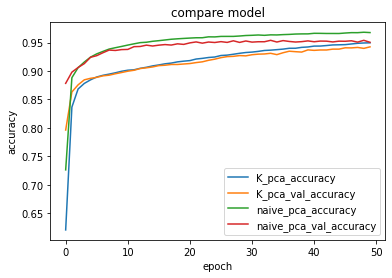

In [23]:
%matplotlib inline
plt.plot(Kpca_history.history['accuracy'])
plt.plot(Kpca_history.history['val_accuracy'])
plt.plot(naive_pca_history.history['accuracy'])
plt.plot(naive_pca_history.history['val_accuracy'])
plt.title('compare model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['K_pca_accuracy', 'K_pca_val_accuracy', 'naive_pca_accuracy', 'naive_pca_val_accuracy'], loc='lower right')
plt.show()

In [ ]:
X_random_train = unlabel_X.reshape(48000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)
X_CNN_train = label_X.reshape(12000, 28, 28, 1)

In [ ]:
CNN_model = build_model()
CNN_random_history = CNN_model.fit(x=X_random_train, y = Y_random, epochs=50, steps_per_epoch=200, batch_size=200, validation_data=(X_test, Y_test))

In [ ]:
print(CNN_model.summary())

In [ ]:
for layer in CNN_model.layers[:]:
  layer.trainable = False

for i in range(-5, 0):
  CNN_model.layers[i].trainable= True

model_status(CNN_model)

In [ ]:
X_label = label_X.reshape(12000, 28, 28, 1)

In [ ]:
CNN_finetune_history = CNN_model.fit(x=X_label, y = Y_label, epochs=50, steps_per_epoch=100, validation_data=(X_test, Y_test))